In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Config

import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from pathlib import Path
import numpy as np
from PIL import Image
import os

In [2]:
VOCAB_SIZE = 30000
MAX_LEN = 128

In [3]:
TOKENIZER_SAVEDIR = Path('/home/macosta/ttmp/primus-data/blocks/blocks-v2-tokenizer/')
LM_MODEL_SAVEDIR = Path('/home/macosta/ttmp/primus-models/gpt2-lm-blocks/')
TXT_FILES = Path('/home/macosta/ttmp/primus-data/blocks/blocks-txt-v2/')

In [4]:
TXT_FILEPATHS = [TXT_FILES / f for f in os.listdir(TXT_FILES)]

In [5]:
config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    n_positions=MAX_LEN,
    n_head=12,
)

In [6]:
model = GPT2LMHeadModel(config=config).from_pretrained(str(LM_MODEL_SAVEDIR))

In [7]:
tokenizer = GPT2TokenizerFast.from_pretrained(TOKENIZER_SAVEDIR, max_len=MAX_LEN)

file /home/macosta/ttmp/primus-data/blocks/blocks-v2-tokenizer/config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
tokenizer.encode('<col>')

[5]

In [9]:
EMPTY = np.ones((15, 15), dtype=np.uint8)

In [10]:
import math, random

In [11]:
def blocks_to_img(tokens):
    tokens = [t for t in tokens if t not in ['<s>', '</s>']]
    columns = ' '.join(tokens).split('<col>')
    columns = [c.strip().split() for c in columns if c]
    columns = [[np.array([int(x) for x in b]).reshape((15, 15)) if b != '<unk>' else EMPTY for b in tokens] for tokens in columns]
    img_arr = np.ones((6 * 15 + 3 * 5, len(columns) * 15), dtype=np.uint8)
    for i, column in enumerate(columns):
        for j in range(min(6, len(column))):
            img_arr[j*18:j*18+15, i*15:i*15+15] = column[j]
    for i in range(15, 15 + 5 * 18 + 1, 18):
        img_arr[i:i+3,:] = 0
    return Image.fromarray(img_arr * 255)

In [23]:
def generate_image(show=False):
    random_file = TXT_FILEPATHS[int(len(TXT_FILEPATHS) * random.random())]
    with open(random_file, 'r') as f:
        file_contents = f.read()
    columns = file_contents.split('<col>')
    columns = [c for c in columns if c]
    random_column = columns[int(len(columns) * random.random())]
    input_str = tokenizer.encode(f'{random_column} <col>', return_tensors='pt')
#     input_str = torch.tensor([[5]])
    output_tokens = model.generate(input_str, 
                                   pad_token_id=1,
                                   eos_token_id=2,
                                   temperature=1,
                                   min_length=MAX_LEN,
                                   max_length=MAX_LEN,
                                   do_sample=True,
                                   bad_words_ids=[[3]])[0]
    assert len(output_tokens) == MAX_LEN
    output_tokens = tokenizer.decode(output_tokens).split()
    img = blocks_to_img(output_tokens)
    return img

In [40]:
def generate_until_end_token(max_extend=512):
#     random_file = TXT_FILEPATHS[int(len(TXT_FILEPATHS) * random.random())]
#     with open(random_file, 'r') as f:
#         file_contents = f.read()
#     columns = file_contents.split('<col>')
#     columns = [c for c in columns if c]
#     random_column = columns[int(len(columns) * random.random())]
#     input_tensors = tokenizer.encode(f'{random_column} <col>', return_tensors='pt')
    input_tensors = torch.tensor([tokenizer.encode('<s>')])
    output_tokens = model.generate(input_tensors, 
                                   pad_token_id=1,
                                   eos_token_id=2,
                                   temperature=1,
                                   min_length=MAX_LEN,
                                   max_length=MAX_LEN,
                                   do_sample=True)
    assert len(output_tokens[0]) == MAX_LEN
    full_sequence = list(output_tokens[0])
    input_tensors = output_tokens[:, 1:]
    for i in tqdm(range(max_extend)):
        output_tokens = model.generate(input_tensors, 
                                   pad_token_id=1,
                                   eos_token_id=2,
                                   temperature=1,
                                   min_length=MAX_LEN,
                                   max_length=MAX_LEN,
                                   do_sample=True)
        assert len(output_tokens[0]) == MAX_LEN
        last_token = output_tokens[0, -1]
        full_sequence.append(last_token)
        if tokenizer.decode(last_token) == '</s>':
            break
        input_tensors = output_tokens[:, 1:]
    full_sequence_decoded = tokenizer.decode(full_sequence).split()
    output = [t for t in full_sequence_decoded if t not in ['<s>', '</s>']]
    img = blocks_to_img(output)
    return img

100%|███████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:22<00:00, 11.41it/s]


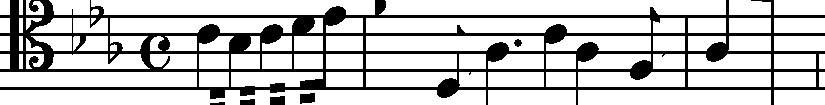

In [42]:
# generate_until_end_token(max_extend=256)

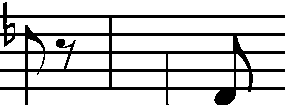

In [28]:
# generate_image(show=True)

In [143]:
def generate_images(n, savepath):
    savepath.mkdir(exist_ok=True)
    for i in tqdm(range(n)):
        img = generate_image()
        img.save(savepath / f"generated-blockwise-{i}.png")

In [49]:
def generate_long_images(n, savepath):
    savepath.mkdir(exist_ok=True)
    for i in range(n):
        img = generate_until_end_token(max_extend=512)
        img.save(savepath / f"generated-blockwise-{i}.png")

In [50]:
generate_long_images(30, savepath=Path('/home/macosta/ttmp/generated-blockwise-long/'))

 14%|████████████                                                                            | 70/512 [00:06<00:38, 11.35it/s]


KeyboardInterrupt: 

In [144]:
# generate_images(30, savepath=Path('/home/macosta/ttmp/generated-blockwise/'))

100%|███████████████████████████████████████████| 30/30 [02:38<00:00,  5.29s/it]
